# Advance Lane Finding
This project implements advance Lane finding using OpenCV. Task of lane finding can be divided into following steps:

### Preprocess Images
In order to detect lane lines in camera images, we first need to transform input images to make it easy for Lane detection

##### Camera Caliberation
Before proceeding with distortion correction of input images, we need to calibrate the camera with known pattern image for which we know the distortion e.g. chesssboard images are good candidate for being symmetrical and high contrast images and we know exactly how they should look like without distortion.

##### Distortion Correction
Undistort input images with distortion coefficients and camera matrix obtained by camera calibration step.

##### Color and Gradient Threshold
Select pixels based on there color or gradient direction thresholds.

#### Region of Interest
Just like first project, we can mask of unwanted surroundings of the lanes to eliminate noise.

##### Perspective Transform
Transform images into birds eye view such that lane lines appear parallel in transformed space

### Lane Detection
Output from preprocessing stage gives us a warped image which is in much better shape to identify lane lines

##### Sliding Window Search
To detect lane lines in the warped image, we use sliding window convolution approach described in lessons. Convolution over vertical slices of the image helps us identify pixels with highest convolution in each slices. Next we fit a second degree polynomial to these selected pixels for left and right lines to draw the lines

##### Measuring Curvature
For measuring curvature radius of the polynomial obtained for the lane lines, we first convert pixels positions into meters and fit the polynomial again with these points in meters units. Following formulta gives us radius of curvature as described in lessons.

\begin{align}
R_{curve} = \frac{(1 + (2Ay+B)^2)^{3/2}}{|2A|}
\end{align}


### Display Detected Lanes
Finally display lanes detected by overlaying on input images. But we have lanes detected in Warped image space. Following steps are used to display detected images:
1. Create a polygon mask for detected lanes
2. unwarp the mask using inverse perpective transformation matrix that was obtained during perpective transformation of preprocessing stage
2. Overlay the mask over undistorted image

### Video Processing
For some images, it may not always be sufficient that above image processing pipeline can detect lane lines, specially images with mix of sunlights and shades to create patches on lanes which can create noise for picking up lanes. While processing video image, we can take advantage of knoledge obtained from previous frames to help detect lane lines in next frame. This make our video processing pipeline stateful and we use python classes to store this useful state informtion from previous frame. We design following two classes:

##### Line Class
For both left and right lines of the image, we create this class. It maintains following useful states:
1. A rolling queue of previous n frames pixels that were used to obtain line fit. We use these points along with new frames lane pixels to obtain a new fit for the frame.
2. A rolling queue of previous n frames polynomial fit. We use it along with new frames fit to obtain a weighted average fit for the new frame. Ofcourse the new frames get higher weights.
3. Radius of curvature of the last fit
4. distance of line from camera center

To find a fit line, we would normally be using previous fit which is averaged over last 'n' frames. However it may be possible that region around previous polynomial does not contain pixels for the line in new frame. In these situations, we want to retry looking for lines using search from scratch with sliding window convolution method as described in Lane Detection section above. But how do we detect that current fit is not good? We define a confidence factor for the fit like this:

\begin{align}
confidence = \frac{VerticalPixelsProbability}{HorizontalPixelsVariance}
\end{align}

A fine lane with longer vertical length and lower horizontal spread would have higher confidence value than a lane pixels with shorter vertical length (e.g. gaps for dashed lines) and wider horizontal distribution (e.g. noise due to tree shades) would have lower confidence value. If confidence falls below certain low threshold, we would retry lane detection with sliding window convolution. Even after retrial with sliding window, if we are not able to detect the high confidence line, we simply discard this frame.

##### LaneGenerator Class
This is the main class for the pipeline which has following states:
1. Line classes for left and right line
2. Average width of the lane in pixels
3. undistorted image
4. Warped Image
5. Invert perspective transformation matrix

This class has combined view for both the lanes and can force switching back to sliding window convolution search if:
1. Top and bottom width between two lane lines varies by 20%
2. Bottom lane width is off by 20% compared to average lane width so far
2. Radius of curvate is off by 20% between two lane lines

## Preprocess Images

### Camera Calibration
As a first step in calibrating camera, obtain image points in distorted images by finding internal corners and map them to object points.

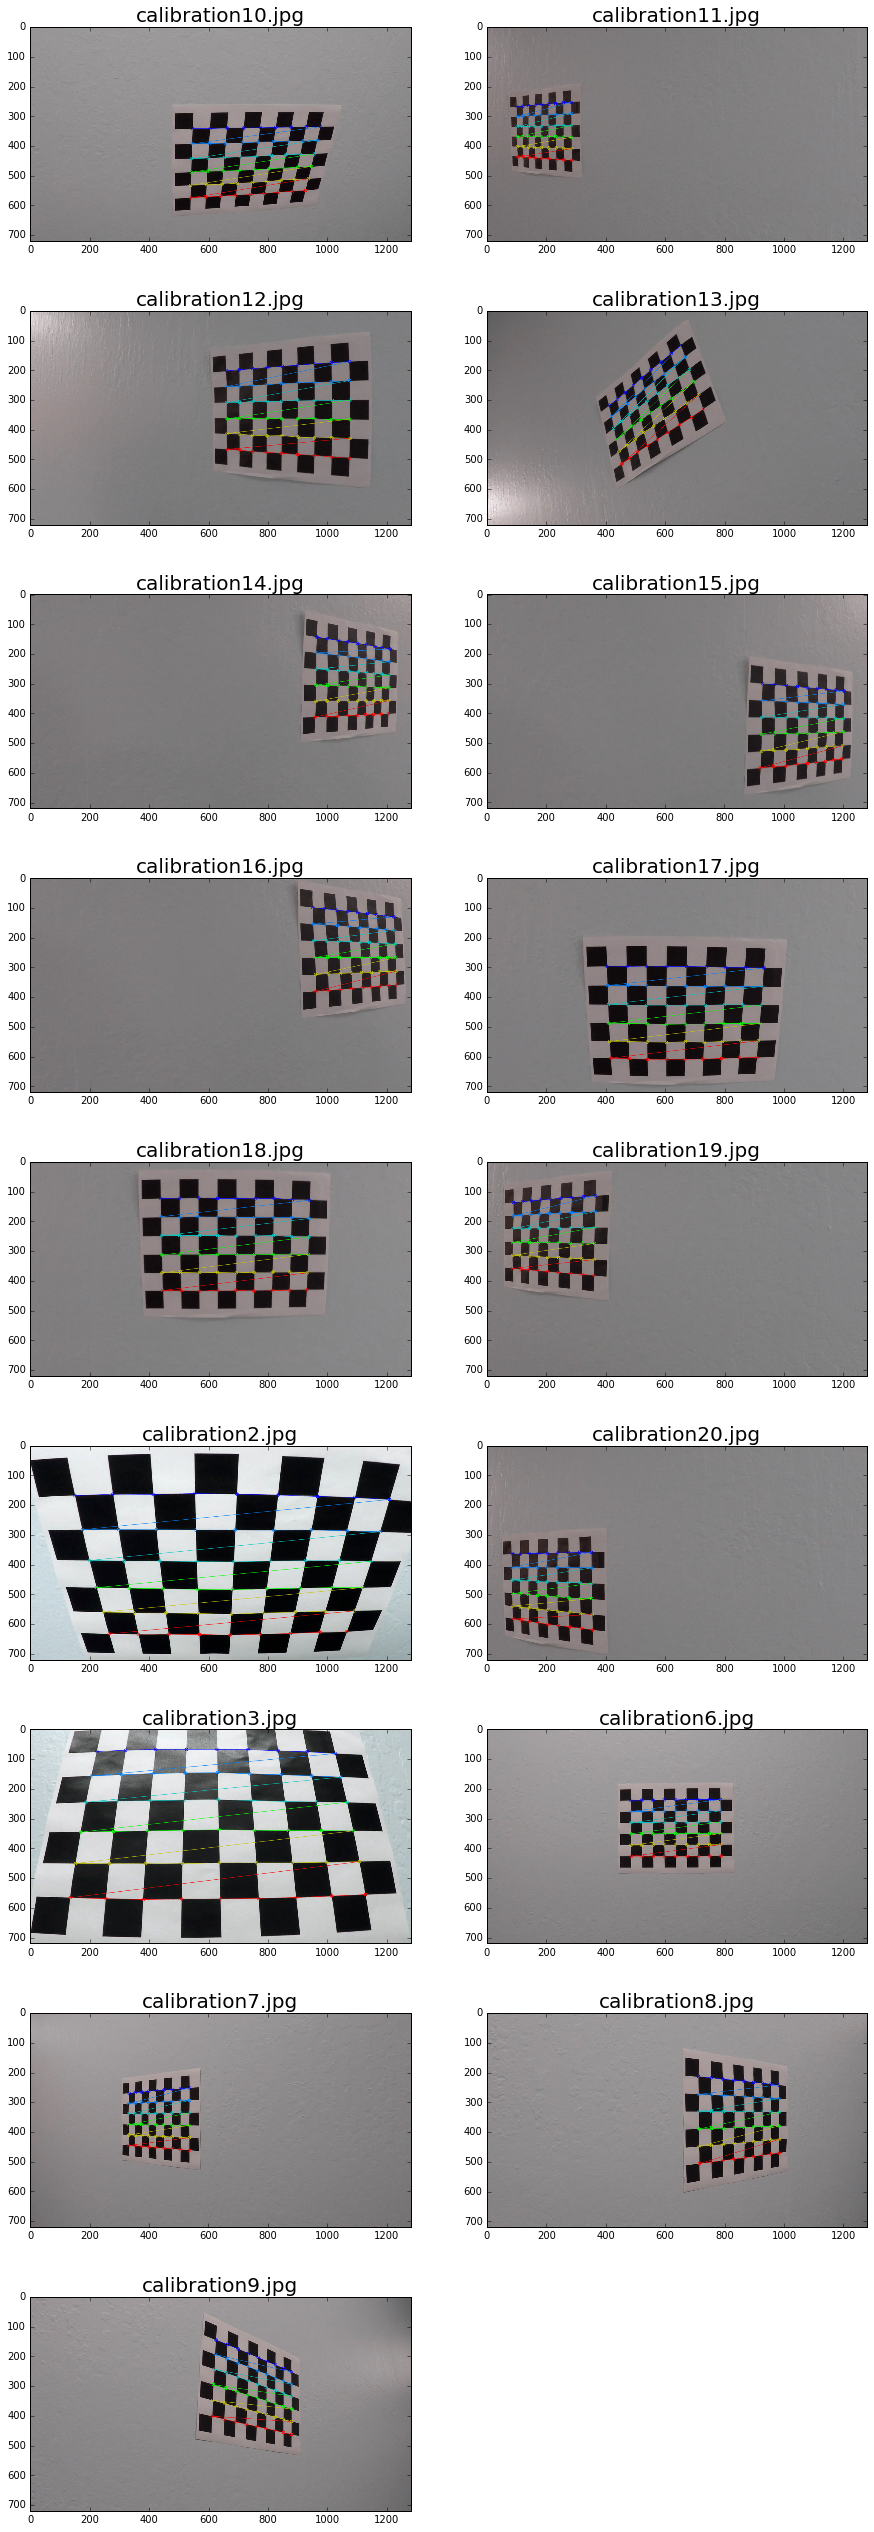

In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

image_points = [] # 2d points in image fram
obj_points = [] # 3d points in real world

# Internal corner points dimensions in chessboard images
ny, nx = (6, 9)

# create 3d object points as all internal corner points in chesboard
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Read all calibration images and find corners
cal_images = sorted(glob.glob('./camera_cal/calibration*.jpg'))
pltnum = 1
n_cols = 2
n_rows = (len(cal_images) + n_cols -1)//n_cols
plt.figure(figsize=(15, 50))
for imfile in cal_images:
    image = cv2.imread(imfile)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        image_points.append(corners)
        obj_points.append(objp)
        
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        plt.subplot(n_rows, n_cols, pltnum)
        plt.title(imfile.split('/')[-1], fontsize='20')
        plt.imshow(image)
        pltnum += 1

Calibrate camera with image and object points

In [2]:
test_image = cv2.imread('./camera_cal/calibration1.jpg')

# Note that calibrateCamera accepts image_size as (width, height)
ret, cam_mtx, dist_coeff, rvecs, tvecs = \
    cv2.calibrateCamera(obj_points, image_points, test_image.shape[1::-1], None, None)

### Distortion Correction
Undistort images using the camaera matrix and distortion coefficients found by camera calibration above

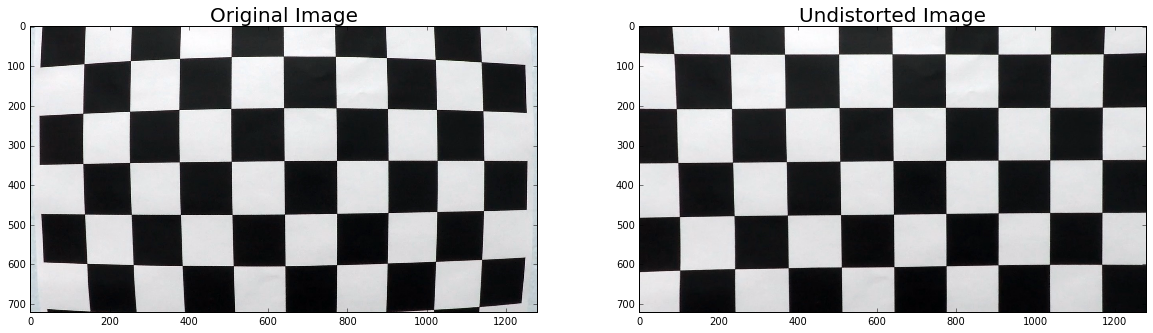

In [3]:
def undistort(image):
    return cv2.undistort(image, cam_mtx, dist_coeff, None, cam_mtx)

undist_image = undistort(test_image)

%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
axs[0].imshow(test_image)
axs[0].set_title('Original Image', fontsize='20')
axs[1].imshow(undist_image)
axs[1].set_title('Undistorted Image', fontsize='20')

Now Let's try undistortion on a test image

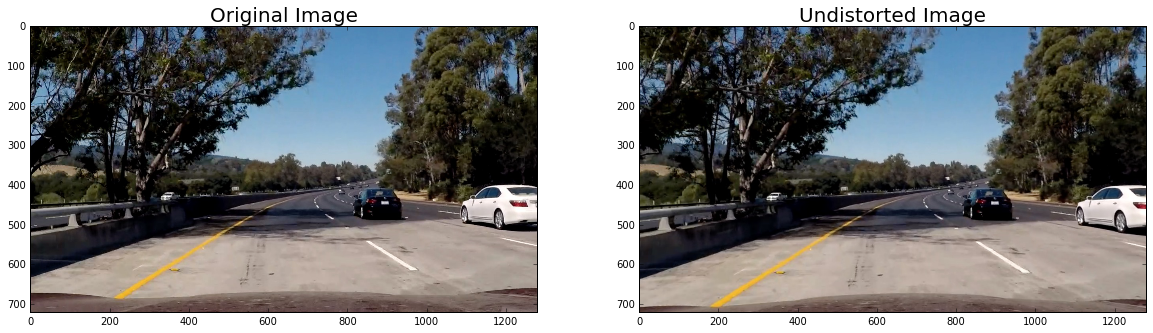

In [4]:
import matplotlib.image as mpimg

test_image = mpimg.imread('./test_images/test5.jpg')
undist_image = undistort(test_image)

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
axs[0].imshow(test_image)
axs[0].set_title('Original Image', fontsize='20')
axs[1].imshow(undist_image)
axs[1].set_title('Undistorted Image', fontsize='20')

### Color and Gradient Threshold


Below code dispalys different color channels in RGB, HLS, HSV, YUV and Lab space to input test image. Note that the Saturation channels represents image in interesting ways where lane lines appear bright in contrast to surrounding lane image. Similarly YUV U channel and Lab b-channel (Blue-Green) can pick up yellow line alone.

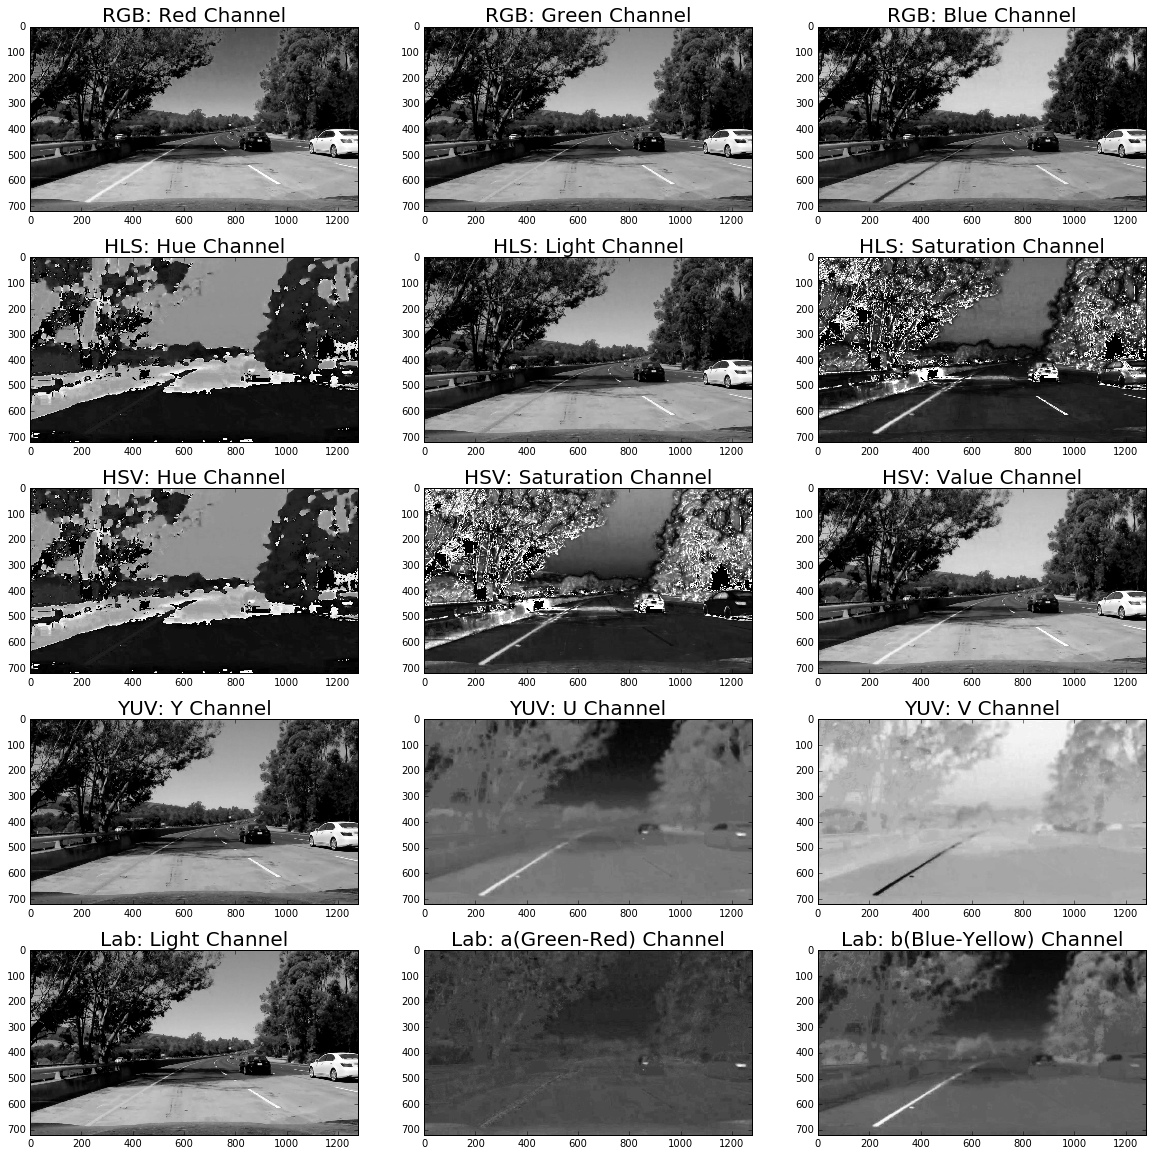

In [5]:
# RGB Color spaces
RGB_r_channel = test_image[:,:,0]
RGB_g_channel = test_image[:,:,1]
RGB_b_channel = test_image[:,:,2]

# convert input image to HLS color space
hls = cv2.cvtColor(test_image, cv2.COLOR_RGB2HLS)
HLS_h_channel = hls[:,:,0]
HLS_l_channel = hls[:,:,1]
HLS_s_channel = hls[:,:,2]

# convert input image to HSV color space
hsv = cv2.cvtColor(test_image, cv2.COLOR_RGB2HSV)
HSV_h_channel = hsv[:,:,0]
HSV_s_channel = hsv[:,:,1]
HSV_v_channel = hsv[:,:,2]

# convert input image to HSV color space
yuv = cv2.cvtColor(test_image, cv2.COLOR_RGB2YUV)
YUV_y_channel = yuv[:,:,0]
YUV_u_channel = yuv[:,:,1]
YUV_v_channel = yuv[:,:,2]

# convert input image to Lab color space
Lab = cv2.cvtColor(test_image, cv2.COLOR_RGB2Lab)
Lab_l_channel = Lab[:,:,0]
Lab_a_channel = Lab[:,:,1]
Lab_b_channel = Lab[:,:,2]

# Plot original and threshold image
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
axs[0][0].imshow(RGB_r_channel, cmap='gray')
axs[0][0].set_title('RGB: Red Channel', fontsize='20')
axs[0][1].imshow(RGB_g_channel, cmap='gray')
axs[0][1].set_title('RGB: Green Channel', fontsize='20')
axs[0][2].imshow(RGB_b_channel, cmap='gray')
axs[0][2].set_title('RGB: Blue Channel', fontsize='20')
axs[1][0].imshow(HLS_h_channel, cmap='gray')
axs[1][0].set_title('HLS: Hue Channel', fontsize='20')
axs[1][1].imshow(HLS_l_channel, cmap='gray')
axs[1][1].set_title('HLS: Light Channel', fontsize='20')
axs[1][2].imshow(HLS_s_channel, cmap='gray')
axs[1][2].set_title('HLS: Saturation Channel', fontsize='20')
axs[2][0].imshow(HSV_h_channel, cmap='gray')
axs[2][0].set_title('HSV: Hue Channel', fontsize='20')
axs[2][1].imshow(HSV_s_channel, cmap='gray')
axs[2][1].set_title('HSV: Saturation Channel', fontsize='20')
axs[2][2].imshow(HSV_v_channel, cmap='gray')
axs[2][2].set_title('HSV: Value Channel', fontsize='20')
axs[3][0].imshow(YUV_y_channel, cmap='gray')
axs[3][0].set_title('YUV: Y Channel', fontsize='20')
axs[3][1].imshow(YUV_u_channel, cmap='gray')
axs[3][1].set_title('YUV: U Channel', fontsize='20')
axs[3][2].imshow(YUV_v_channel, cmap='gray')
axs[3][2].set_title('YUV: V Channel', fontsize='20')
axs[4][0].imshow(Lab_l_channel, cmap='gray')
axs[4][0].set_title('Lab: Light Channel', fontsize='20')
axs[4][1].imshow(Lab_a_channel, cmap='gray')
axs[4][1].set_title('Lab: a(Green-Red) Channel', fontsize='20')
axs[4][2].imshow(Lab_b_channel, cmap='gray')
axs[4][2].set_title('Lab: b(Blue-Yellow) Channel', fontsize='20')

First we will implement gradient thresholding of images. A combination of following thresholds can help better detect lane lines

1. Thresholding gradient along x axis
2. Thresholding gradient along y axis
3. Thresholding magnitute of gradient in both x and y axis
4. Thresholding on gradient orientation

Color threshold is simply thresholding a color channel of image. We use combination of RGB and Lab color space to pickup lane line pixels. Here I have leveraged ideas from [Joshua Owoyemi](https://medium.com/@tjosh.owoyemi/finding-lane-lines-with-colour-thresholds-beb542e0d839) for picking yellow and white lane images.

In [6]:
# paramenter to control smoothness in gradient
SOBEL_KSIZE = 9

# Return sobel value scaled to 0-255
def scale_image(image):
    return np.uint8(255*image/np.max(image))

# Returns binary image with values filtered by threhold range
def get_binary_threshold(input_img, thresh):
    binary_output = np.zeros_like(input_img)
    binary_output[(input_img >= thresh[0]) & (input_img <= thresh[1])] = 1
    return binary_output

# Returns gradient thresholded image from single channel input image 'img'
def get_gradient_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    HLS_l_channel = hls[:,:,1]
    HLS_s_channel = hls[:,:,2]
    
    # Get image gradients with Sobel Operator
    sobelx = cv2.Sobel(HLS_s_channel, cv2.CV_64F, 1, 0, ksize=SOBEL_KSIZE)
    sobely = cv2.Sobel(HLS_s_channel, cv2.CV_64F, 0, 1, ksize=SOBEL_KSIZE)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    
    # Scale gradients
    scaled_sobelx = scale_image(abs_sobelx)
    scaled_sobelxy = scale_image(abs_sobelxy)
    
    # Direction of gradient
    grad_direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # Get thresholded binary images
    grad_x_thresh = get_binary_threshold(scaled_sobelx, thresh=(10, 200))
    grad_xy_thresh = get_binary_threshold(scaled_sobelxy, thresh=(100, 255))
    grad_dir_thresh = get_binary_threshold(scaled_sobelxy, thresh=(np.pi/6, np.pi/2))
    
    # Filter out dark points
    HLS_l_threshold = get_binary_threshold(HLS_l_channel, thresh=(100, 255))
    
    # Create a combined binary image
    combined = np.zeros_like(grad_dir_thresh)
    combined[(HLS_l_threshold == 1) & \
             ((grad_x_thresh == 1) | \
              ((grad_dir_thresh == 1) & (grad_xy_thresh == 1)))] = 1
    combined = cv2.GaussianBlur(combined, (9,9), 0, 0)
    return combined

# Select pixels from RGB image between rgb_min and rgb_max range
def get_rgb_color_threshold(img, rgb_min, rgb_max):
    rgb_mask = cv2.inRange(img, rgb_min, rgb_max)
    color_masked = cv2.bitwise_and(img, img, mask=rgb_mask)
    gray_masked = cv2.cvtColor(color_masked, cv2.COLOR_RGB2GRAY)
    return get_binary_threshold(gray_masked, thresh=(20, 255))
    
def get_color_threshold(img):
    # Pick up white pixels from RBG image
    min_white = np.array([100, 100, 200], dtype=np.uint8)
    max_white = np.array([255, 255, 255], dtype=np.uint8)
    rgb_w_thresh = get_rgb_color_threshold(img, min_white, max_white)
    
    # Pick up yellow line pixels from RGB image
    min_yellow = np.array([225, 180, 0], dtype=np.uint8)
    max_yellow = np.array([255, 255, 170], dtype=np.uint8)
    rgb_y_thresh = get_rgb_color_threshold(img, min_yellow, max_yellow)

    # As seen Above, Lab color space b channel can also isolate yellow line
    # in contrast to background lane. Additionally threshold based on Light
    # channel to filter out dark patches of shades
    Lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    Lab_L_channel = Lab[:,:,0]
    Lab_b_channel = Lab[:,:,2]
    Lab_L_thresh = get_binary_threshold(Lab_L_channel, thresh=(100, 255))
    Lab_b_thresh = get_binary_threshold(Lab_b_channel, thresh=(175, 255))
    
    combined = np.zeros_like(Lab_b_thresh)
    combined[((rgb_w_thresh == 1) | (rgb_y_thresh == 1) | (Lab_b_thresh == 1)) & (Lab_L_thresh == 1)] = 1
    return combined

Code below demostrate color and gradient thresholds and their combined output which can identify lane lines in contrast to background

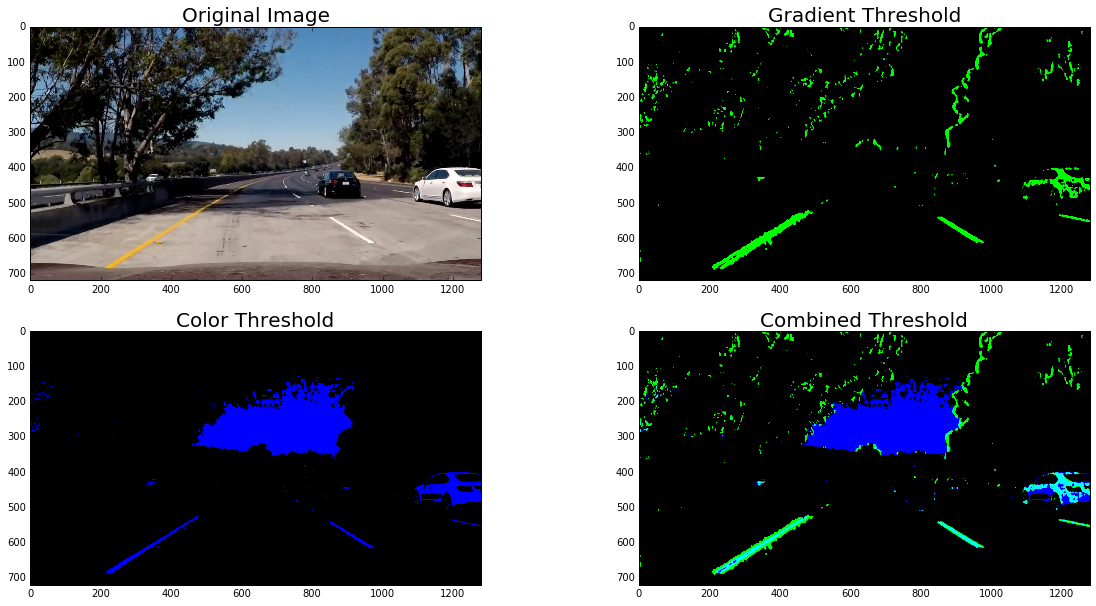

In [7]:
# Get gradient thresholded image
gradient_threshold = get_gradient_threshold(test_image)
color_threshold = get_color_threshold(test_image)

# Green channel gradient image
gradient_image = np.dstack((np.zeros_like(gradient_threshold), \
                            gradient_threshold, \
                            np.zeros_like(gradient_threshold)))*255

# Blue channel color image
color_image = np.dstack((np.zeros_like(color_threshold), \
                         np.zeros_like(color_threshold), \
                         color_threshold))*255

# Blue and Green Channel combined image
combined_image = np.dstack((np.zeros_like(color_threshold), \
                            gradient_threshold, \
                            color_threshold))*255

# Plot original and threshold image
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axs[0][0].imshow(test_image)
axs[0][0].set_title('Original Image', fontsize='20')
axs[0][1].imshow(gradient_image)
axs[0][1].set_title('Gradient Threshold', fontsize='20')
axs[1][0].imshow(color_image)
axs[1][0].set_title('Color Threshold', fontsize='20')
axs[1][1].imshow(combined_image)
axs[1][1].set_title('Combined Threshold', fontsize='20')

Following piece of code to mask off unwanted region was obtained from first lane finding project with slight adjustment: An 'outer' argument is added to mask of region ouside or inside the polygon. We use this functionality to remove noise from region between the two lane lines

In [8]:
def region_of_interest(img, vertices, outer=True):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    if outer == True:
        ignore_color = 255
        mask = np.zeros_like(img)
    else:
        ignore_color = 0
        mask = np.ones_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (ignore_color,) * channel_count
    else:
        ignore_mask_color = ignore_color
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

We have color and gradient trheshold, region of interest, now lets obtain an image which just focuses over the current lane lines only

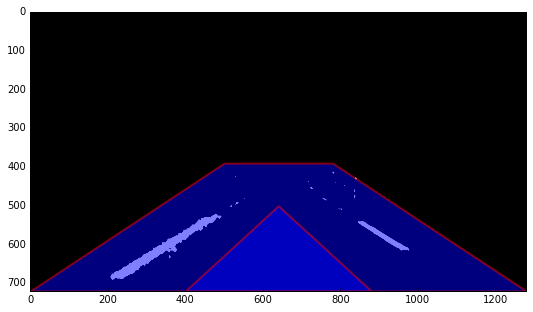

In [9]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def get_color_gradient_threshold(img, display=False):
    # Get color and gradient thresholds
    gradient_threshold = get_gradient_threshold(img)
    color_threshold = get_color_threshold(img)
    
    # Combine thresholds
    combined_threshold = np.zeros_like(color_threshold)
    combined_threshold[(gradient_threshold == 1) | (color_threshold == 1)] = 1
    
    # Mask off unwanted region of image
    ysize, xsize = combined_threshold.shape
    mask_outer = np.int32([[500, 390],
                           [xsize - 500, 390],
                           [xsize, ysize],
                           [0, ysize]])
    masked = region_of_interest(combined_threshold, [mask_outer])
    mask_inner = np.int32([[xsize//2, 500],
                           [xsize//2, 500],
                           [xsize - 400, ysize],
                           [400, ysize]])
    masked = region_of_interest(masked, [mask_inner], outer=False)
    
    if display == True:
        fig = plt.figure(figsize=(10,5))
        plt.imshow(masked, cmap='gray')
        poly = Polygon(mask_outer)
        p = PatchCollection([poly], alpha=0.5, edgecolor='red', linewidth=2)
        fig.axes[0].add_collection(p)
        poly = Polygon(mask_inner)
        p = PatchCollection([poly], alpha=0.5, edgecolor='red', linewidth=2)
        fig.axes[0].add_collection(p)
    return masked

thresholded_image = get_color_gradient_threshold(test_image, display=True)

### Perspective Transform

Below function returns a warped image from an undistorted lane image to obtain a bird-eye perpective of the lane image. source and destination points have been chosen with multiple trial and errors such that a polygon with edges parallel to lane lines are transformed into a rectanle after tranformation. Parameter dispaly=True can be used to visualize how this transformation is done.

This function also returns inverse transformation matrix which would later be used to transform back to original undistorted image space.

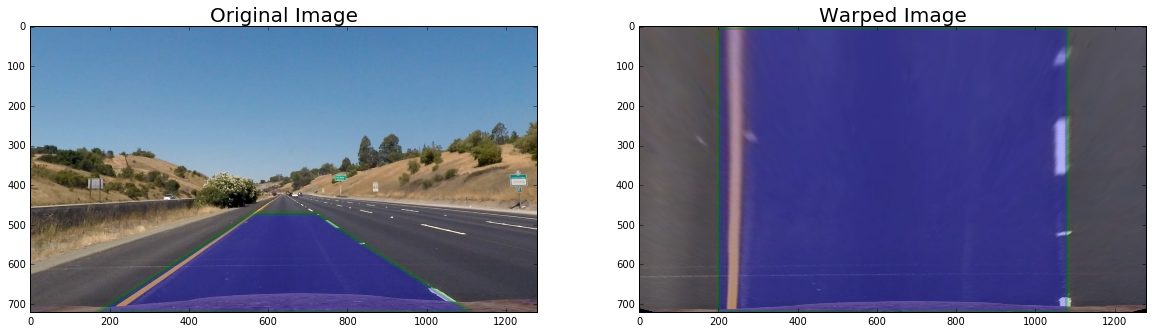

In [10]:
def perspective_transform(img, display=False):  
    xsize = img.shape[1]
    ysize = img.shape[0]
    src_pts = np.float32([[560, 470],
                          [xsize - 560, 470],
                          [xsize - 170, ysize],
                          [170, ysize]])
    
    offset = 200
    dst_pts = np.float32([[offset, 0],
                          [xsize - offset, 0],
                          [xsize - offset, ysize],
                          [offset, ysize]])
    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    # Save inverse transform matrix to later come back to real world space
    Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    
    warped = cv2.warpPerspective(img, M, (xsize, ysize))

    if display == True:
        # Plot original and warped image
        fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
        axs[0].imshow(img)
        poly = Polygon(src_pts)
        p = PatchCollection([poly], alpha=0.3, edgecolor='green', linewidth=5)
        axs[0].add_collection(p)
        axs[0].set_title('Original Image', fontsize='20')
        axs[1].imshow(warped, cmap='gray')
        poly = Polygon(dst_pts)
        p = PatchCollection([poly], alpha=0.3, edgecolor='green', linewidth=5)
        axs[1].add_collection(p)
        axs[1].set_title('Warped Image', fontsize='20')

    return warped, Minv

def get_warped_image(img):
    thresh_img = get_color_gradient_threshold(img)
    return perspective_transform(thresh_img)

test_image = mpimg.imread('./test_images/straight_lines1.jpg')
undist = undistort(test_image)
warped_image, Minv = perspective_transform(undist, display=True)

## Lane Detection
We have obtained the warped image with birds-eye view of the lane lines, now lets jump into detection of lane lines

### Sliding Window Search
Below cell implements sliding window convolution approach to find poteintial candiadate lane line pixels. Following are hightlights for the below alogirthm:
1. Obtain an initial estimate for left and right lane center by looking into bottom quarter of the image using convolution of small window of 80x50 pixels of ones over this vertical slice. Left line is searched only in first half (horizontally) of the image while right lane line is searched in second half.
  - If there are not enough pixels in bottom quarter, we expand this vertical slice to bottom half, 3 quarters and finally to full image. Even after this if we fail, just give up on this frame.
2. Next we search for line pixels on more granular vertical slices and repeat following setps:
  - Search for pixels around line center obtained in previous step with a horizonal margin of 100 around the center. Use convolution again to find pixels with highest density to find new values for line center.
  - Create a window mask around this line center to select only the pixels within this window from the current vertical slice. width of the window at each vertical slice is 2*margin =  200 pixels
3. At this point, we should have a image mask which can be used to select only the pixels that represent this line.

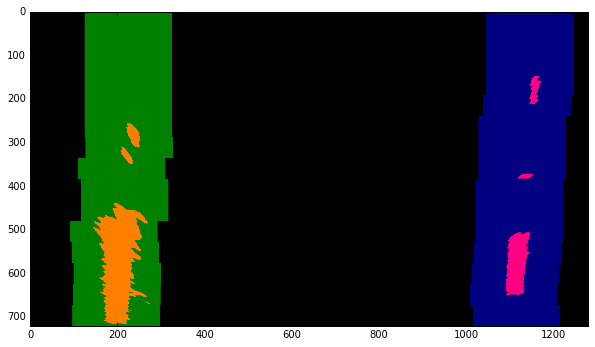

In [11]:
import sys

# Convoluation window size
window_width = 50
window_height = 48
margin = 100 # Search margin around window
min_sum = 50 # minimum sum of pixels in search area to consider a new window

# Find window center convolution in area bounded by box (x1, y1), (x2, y2)
def find_window_center(img, y1, y2, x1, x2):
    window = np.ones(window_width)
    xsum = np.sum(img[y1:y2,x1:x2], axis=0)
    
    # If not enough inputs in search window, return error
    if np.sum(xsum) < min_sum:
        return -1
    
    # NOTE: convolution is maximum at the end of the window, so position of
    # window center is position of max convolution - window_width/2
    return np.argmax(np.convolve(window, xsum)) + x1 - window_width/2
 
# Returns mask image for selecting left and right lane pixels
def get_sliding_window_mask(img, left=True):
    mask = np.zeros_like(img)

    # Lane lines are more profounds near the camera, get line center
    # with convolution on bottom portion of the image. We will use
    # these centers as starting point for search in each vertical level
    center = -1
    x_min = 0
    x_max = img.shape[1]//2
    if left == False:
        x_min = x_max
        x_max = img.shape[1]

    # Start searching for line pixels with bottom quarter of the image, if not enough
    # pixels in last quarter, search in lower half and so on..
    for i in range(3, -1, -1):
        center = find_window_center(img, y1=img.shape[0]*i//4, y2=img.shape[0], x1=x_min, x2=x_max)
        if center != -1:
            break
    if center == -1:
        raise ValueError('Line could not be detected')
     
    # Find windows at each vertical level
    for i in range(0, img.shape[0]//window_height):
        y_max = int(img.shape[0] - i * window_height)
        y_min = int(y_max - window_height)
        
        # Searching at each level is narrowed down with previous centroids +- margin,
        # if new window center could not be found, reuse previous center
        if left == True:
            x_min = int(max(center-margin, 0))
            x_max = int(min(center+margin, img.shape[1]//2))
        else:
            x_min = int(max(center-margin, img.shape[1]//2))
            x_max = int(min(center+margin, img.shape[1]))
        ret = find_window_center(img,  y1=y_min, y2=y_max, x1=x_min, x2=x_max)
        if ret != -1:
            center = ret
        
        # Update lane masks with new window centers
        mask[y_min:y_max, int(max(center-margin, 0)):int(min(center+margin,mask.shape[1]))] = 1
        
    return mask

# Let's try plotting windows on a warped image
test_image = mpimg.imread('./test_images/test5.jpg')
undist = undistort(test_image)
warped_image, Minv = get_warped_image(undist)
l_mask = get_sliding_window_mask(warped_image, True)
r_mask = get_sliding_window_mask(warped_image, False)
src_image = np.dstack((warped_image, np.zeros_like(warped_image), np.zeros_like(warped_image)))*255
window_image = np.dstack((np.zeros_like(l_mask),)*3)
window_image[l_mask == 1] = (0,255,0)
window_image[r_mask == 1] = (0,0,255)
window_image = cv2.addWeighted(src_image, 1, window_image, 0.5, 0.0)
plt.figure(figsize=(10,15))
plt.imshow(window_image)

Now we have the narrowed down range to look for lane lines, now lets fit a polynomial to lane points in the window.

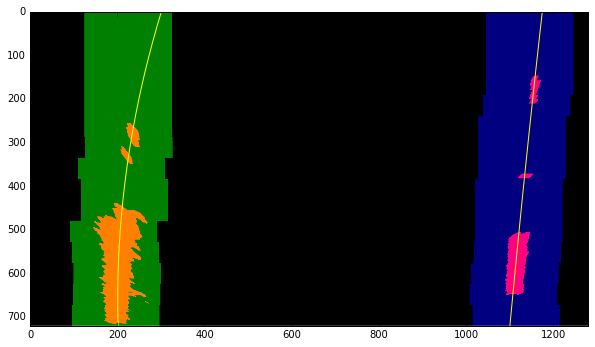

In [12]:
def fit_polynomial(img, mask):
    lane_image = np.bitwise_and(img, mask)
    nonzero = lane_image.nonzero()
    xpts = nonzero[1]
    if xpts.size == 0:
        return None, 0
    ypts = nonzero[0]
    if ypts.size == 0:
        return None, 0
    return np.polyfit(ypts, xpts, 2)

# Detect lane lines and display them
def detect_lanes(warped_image, l_mask, r_mask):
    # Fit polynomial to lane pixels within masked windows
    l_fit = fit_polynomial(warped_image, l_mask)
    r_fit = fit_polynomial(warped_image, r_mask)

    # Draw lane lines
    yrange = np.linspace(0, warped_image.shape[0]-1, num=warped_image.shape[0])
    left_fitx = l_fit[0]*yrange**2 + l_fit[1]*yrange + l_fit[2]
    right_fitx = r_fit[0]*yrange**2 + r_fit[1]*yrange + r_fit[2]
    
    # Create image with lane windows around lane
    src_image = np.dstack((warped_image, np.zeros_like(warped_image), np.zeros_like(warped_image)))*255
    window_image = np.dstack((np.zeros_like(l_mask),)*3)
    window_image[l_mask == 1] = (0,255,0)
    window_image[r_mask == 1] = (0,0,255)
    window_image = cv2.addWeighted(src_image, 1, window_image, 0.5, 0.0)
    plt.figure(figsize=(10,15))
    plt.imshow(window_image)
    
    # Plot polynomial lines
    plt.plot(left_fitx, yrange, color='yellow')
    plt.plot(right_fitx, yrange, color='yellow')
    plt.xlim(0, warped_image.shape[1])
    plt.ylim(warped_image.shape[0], 0)

def detect_init_lanes(warped_image):
    l_mask = get_sliding_window_mask(warped_image, True)
    r_mask = get_sliding_window_mask(warped_image, False)
    detect_lanes(warped_image, l_mask, r_mask)
    
detect_init_lanes(warped_image)

While we can use sliding window convoltuion to obtain the window masks to search for lane pixels and fit the polynomial. However when we already have a polynomial fit, we can obtain a mask around the existing polynomial and search for line pixels in windows around this polynomial. E.g. it would be useful when processing video frames where its likely to find line pixels around polynomial fit from previous frame.

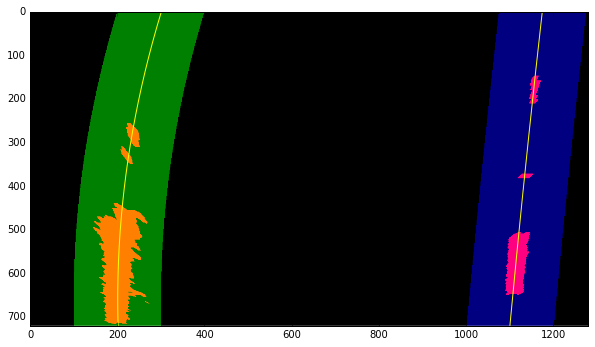

In [13]:
# Returns lane window mask from polyfit
def get_polynomial_mask(warped_image, fit):
    mask = np.zeros_like(warped_image)
    yrange = np.linspace(0, warped_image.shape[0]-1, num=warped_image.shape[0])
    fitx = np.uint32(fit[0]*yrange**2 + fit[1]*yrange + fit[2])
    for i in range(warped_image.shape[0]):
        mask[i,fitx[i]-margin:fitx[i]+margin] = 1
    return mask

# Fit polynomial with previous mask
l_mask = get_sliding_window_mask(warped_image, left=True)
r_mask = get_sliding_window_mask(warped_image, left=False)
l_fit = fit_polynomial(warped_image, l_mask)
r_fit = fit_polynomial(warped_image, r_mask)
l_mask = get_polynomial_mask(warped_image, l_fit)
r_mask = get_polynomial_mask(warped_image, r_fit)
detect_lanes(warped_image, l_mask, r_mask)

We have a polyfit for the lane lines, we can use it to obtain its radius of curvature and distance from camera center image. However there is a slight problem, everythings is in pixels space and values are meaningful when expressed as meters so that they can repesent real world metric. To do so, we first convert x and y positions of pixels into meters and fit the polynomial to these pixels in meter space.

In [14]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
# Get Curvature and distance from center
def get_curvature_radius(img, xpts):
    yrange = np.linspace(0, img.shape[0]-1, num=img.shape[0])

    # convert input to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    yrange_m = yrange * ym_per_pix
    xpts_m = xpts * xm_per_pix
    
    fit_m = np.polyfit(yrange_m, xpts_m, 2)

    ymax_m = yrange_m[-1]
    
    radius = (1 + (2*fit_m[0]*ymax_m + fit_m[1])**2)**1.5/np.absolute(2*fit_m[0])
    return radius

# Get distance of center of vehile from line
def get_line_distance(img, xpts):
    return (xpts[-1] - img.shape[1]/2)*xm_per_pix

def get_lane_pos_metrics(img, leftx, rightx):
    # Find curvature radius of the lane
    left_radius = get_curvature_radius(img, leftx)
    right_radius = get_curvature_radius(img, rightx)
    radius = (left_radius + right_radius)/2
    
    # Find distance of image center (camera) from lane center
    left_distance = get_line_distance(img, leftx)
    right_distance = get_line_distance(img, rightx)
    center_distance = (left_distance + right_distance)/2
    
    return (radius, center_distance)

## Display Detected Lanes

We have idetified the lane lines, its time to project the detected lanes over undistorted input image. We use opencv fillPoly method to create a lane mask. Code was presented in lessons. The main trick here is to map lines diagonally between two lanes such that fillPoly can obtain countour around each lines and fill the space within (Brilliant!)

Next we transform this mask image into realworld space with inverse perpective transformation matrix and overlay it over undistorted lane image.

As last step, we add text on image to display radius of curvature and vehicle position w.r.t. lane center.

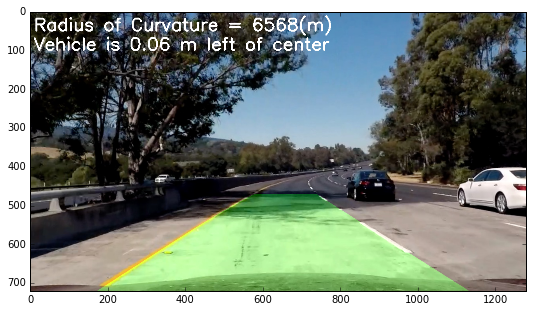

In [15]:
def get_marked_lane(warped_img, undist_img, Minv, lfit, rfit):
    yrange = np.linspace(0, warped_img.shape[0]-1, num=warped_img.shape[0])
    left_fitx = lfit[0]*yrange**2 + lfit[1]*yrange + lfit[2]
    right_fitx = rfit[0]*yrange**2 + rfit[1]*yrange + rfit[2]
    
    left_points = np.array([np.transpose(np.vstack([left_fitx, yrange]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yrange])))])
    lane_points = np.int_(np.hstack((left_points, right_points)))
    
    lane_mask = np.dstack((np.zeros_like(warped_img),)*3).astype(np.uint8)
    cv2.fillPoly(lane_mask, [lane_points], (0,255,0))
    
    unwarped_mask = cv2.warpPerspective(lane_mask, Minv, undist_img.shape[1::-1])
    output = cv2.addWeighted(undist_img, 1, unwarped_mask, 0.3, 0)
    
    radius, center_distance = get_lane_pos_metrics(warped_img, left_fitx, right_fitx)
    curvature_text = "Radius of Curvature = {}(m)".format(int(radius))
    center_text = None
    if center_distance >= 0:
        center_text = "Vehicle is {:.2f} m left of center".format(center_distance)
    else:
        center_text = "Vehicle is {:.2f} m right of center".format(-center_distance)
    
    cv2.putText(output, curvature_text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX,
                1.5, color=(255,255,255), thickness=3)
    cv2.putText(output, center_text, (10, 100), cv2.FONT_HERSHEY_SIMPLEX,
                1.5, color=(255,255,255), thickness=3)
   
    return output

final_image = get_marked_lane(warped_image, undist, Minv, l_fit, r_fit)
plt.figure(figsize=(10,5))
plt.imshow(final_image)

Now lets run our pipeline on all test images to see how they detect lane lines.

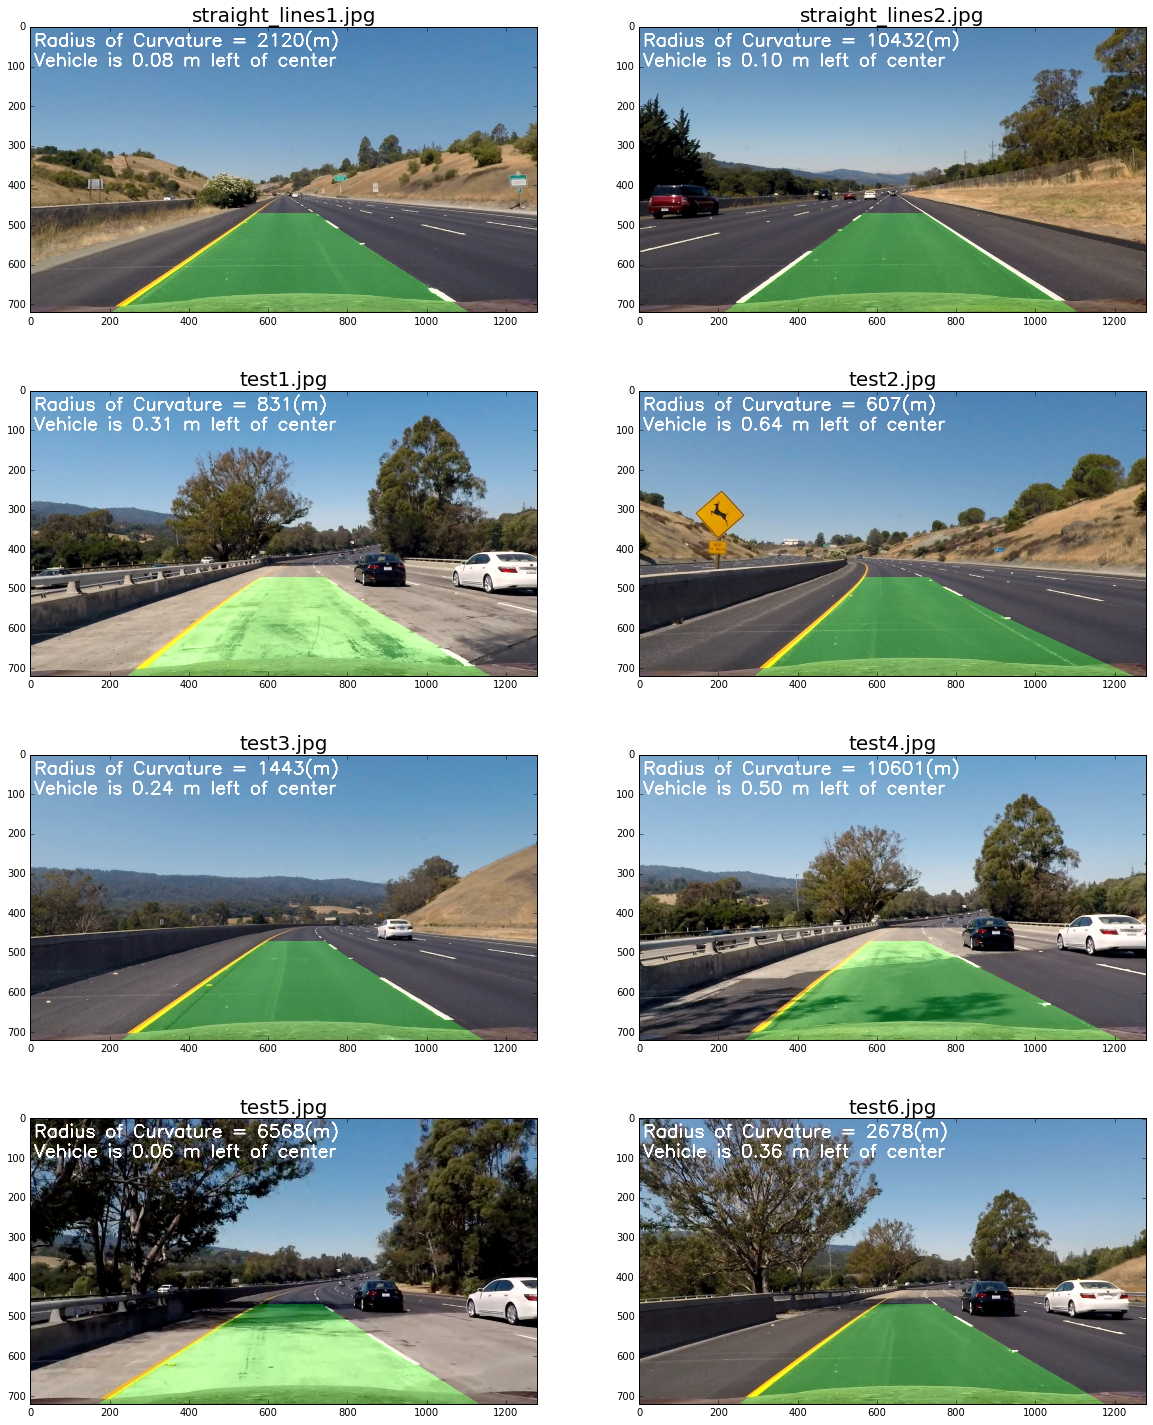

In [16]:
import glob

def detect_lane_lines(input_img):
    undist_img = undistort(input_img)
    warp_img, Minv = get_warped_image(undist_img)
    
    # Fit polynomial to lane pixels within masked windows
    try:
        lmask = get_sliding_window_mask(warp_img, left=True)
        rmask = get_sliding_window_mask(warp_img, left=False)
    except ValueError as e:
        return undist_img
    
    lfit = fit_polynomial(warp_img, lmask)
    rfit = fit_polynomial(warp_img, rmask)
    if (lfit is None) or (rfit is None):
        return undist_img
    
    return get_marked_lane(warp_img, undist_img, Minv, lfit, rfit)

image_files = sorted(glob.glob("./test_images/*.jpg"))
pltnum = 1
n_cols = 2
n_rows = (len(image_files) + n_cols -1)//n_cols
plt.figure(figsize=(20, 25))
for imfile in image_files:
    image = mpimg.imread(imfile)
    result = detect_lane_lines(image)
    plt.subplot(n_rows, n_cols, pltnum)
    plt.title(imfile.split('/')[-1], fontsize='20')
    plt.imshow(result)
    pltnum += 1

## Video Processing
As described in summary above this notebook, we define Line and LaneGenerator classes to make a stateful pipeline. Lets start for with below definition of Line class

In [17]:
from collections import deque

LOW_CONFIDENCE_THRESHOLD = 0.01

class Line():
    def __init__(self, left=True, n_frames=10, debug=False):
        self.left = left # Left or right line?
        self.detected = False # was the line detected in the last iteration?
        self.recent_fit = deque(maxlen=n_frames) # circular buffer of recent frames polynomial fit
        self.recent_pts = deque(maxlen=n_frames) # circular buffer of recent frames points
        self.confidence = 0.0 # Confidence in current frame fit
        self.avg_fit = np.empty(3) # weighted average of recent_fit entries
        self.num_reset = 0 # number of times reset called to switch back to sliding window
        self.curve_radius = 0.0 # radius of curvature
        self.camera_ditance = 0.0 # Distance from camera
        self.debug = debug # Save frames for debugging later
        self.color_line = None # Debug image showing colored line pixels with previous frames included

    def get_confidence(self, img, ypts, xpts):
        xvar = max(np.var(xpts), 1.e-9)
        yprob = len(ypts)/img.shape[0]
        return yprob/xvar
  
    def get_fit_points(self, img, fit):
        fit_y = np.linspace(0, img.shape[0]-1, num=img.shape[0])
        fit_x = fit[0]*fit_y**2 + fit[1]*fit_y + fit[2]
        return fit_y, fit_x
    
    def fit_polynomial(self, img, mask):
        line_image = np.bitwise_and(img, mask)
        nonzero = line_image.nonzero()
        xpts = nonzero[1]
        ypts = nonzero[0]
        if xpts.size == 0:
            return None, 0.0
        
        self.recent_pts.append((ypts, xpts))
        combined_y = np.array([], dtype=np.int_)
        combined_x = np.array([], dtype=np.int_)
        for pts in self.recent_pts:
            combined_y, combined_x = np.concatenate((combined_y, pts[0])), \
                                     np.concatenate((combined_x, pts[1]))
         
        fit = np.polyfit(combined_y, combined_x, 2)
        confidence = self.get_confidence(img, combined_y, combined_x)
        
        if self.debug == True:
            self.color_line = np.dstack((np.zeros_like(mask), mask, np.zeros_like(mask)))*100
            self.color_line[combined_y, combined_x, :] = (0, 0, 255)
            self.color_line[ypts, xpts, :] = (255, 0, 0)
            fit_y, fit_x = self.get_fit_points(img, fit)
            line_points = np.array([np.transpose(np.vstack([fit_x, fit_y]))], dtype=np.int32)
            cv2.polylines(self.color_line, [line_points], False, color=(255,255,0), thickness=2)

        return fit, confidence

    def save_new_fit(self, cur_fit, confidence):
        self.confidence = confidence
        self.recent_fit.append(cur_fit)
        n = len(self.recent_fit)
        self.avg_fit = np.average(self.recent_fit, axis=0, weights=range(1,n+1))
        
    def reset(self):
        self.num_reset += 1
        self.detected = False
        
    def detect(self, warped_img):
        # Get mask to search for line
        mask = None
        while True:
            if self.detected == False:
                # First time or after reset from previous faulty frame,
                # use sliding window to find line
                try:
                    mask = get_sliding_window_mask(warped_img, self.left)
                except ValueError as e:
                    return
            else:
                mask = get_polynomial_mask(warped_img, self.avg_fit)

            cur_fit, confidence = self.fit_polynomial(warped_img, mask)
            if confidence < LOW_CONFIDENCE_THRESHOLD:
                if self.detected == False:
                    # Sliding window search yields low confidence results,
                    # just give on on this frame
                    return
                
                # Polynomial from previous frames is not working with
                # current frame, retry with sliding window search again
                self.reset()
                continue
            
            self.save_new_fit(cur_fit, confidence)
            self.detected = True
            ypts, xpts = self.get_fit_points(warped_img, self.avg_fit)
            self.curve_radius = get_curvature_radius(warped_img, xpts)
            self.camera_distance = get_line_distance(warped_img, xpts)
            break

Below is our LaneDetector class implementation.

In [18]:
PREV_WIDTH_RATIO = 0.6

class LaneDetector():
    def __init__(self, n_frames=10, debug = False):
        self.left_line = Line(left=True, n_frames=n_frames, debug=True) # Left line
        self.right_line = Line(left=False, n_frames=n_frames, debug=True) # Right line
        self.avg_width = 0.0 # Average width of the lane
        self.undist_img = None # undistorted image
        self.warped_img = None # warped image
        self.Minv = None # inverted perspective trnasform matrix
        self.debug = debug
        
        # Stats
        self.num_hits = 0 # number of frames with lane detected
        self.num_miss = 0 # number of frames with no lane detected
    
    def is_width_ok(self, width):
        if self.avg_width == 0.0:
            return True
        if (width < self.avg_width * 0.8) or (width > self.avg_width * 1.2):
            return False
        return True
    
    def is_curve_radius_ok(self):
        if (self.left_line.curve_radius < self.right_line.curve_radius * 0.8) or \
           (self.left_line.curve_radius > self.right_line.curve_radius * 1.2):
            return False
        return True
    
    def get_curve_radius(self):
        return (self.left_line.curve_radius + self.right_line.curve_radius)/2
    
    def get_center_distance(self):
        return (self.left_line.camera_distance + self.right_line.camera_distance)/2
    
    def get_lane_fit(self):
        left_fit, right_fit = None, None
        for retry_cnt in range(2):
            self.left_line.detect(self.warped_img)
            self.right_line.detect(self.warped_img)

            # We have good fit for both left and right lines, average them out
            self.num_hits += 1
            left_fit = self.left_line.avg_fit
            right_fit = self.right_line.avg_fit

            # calculate lane width
            y_max = (self.warped_img.shape[0] - 1)
            top_width = (right_fit[2] - left_fit[2])
            bottom_width = (right_fit[0] - left_fit[0])*y_max**2 + \
                           (right_fit[1] - left_fit[1])*y_max + \
                           top_width
            # If lanes are not aligned or not apart by average width or curve radius are not similar,
            # reset lane detection and retry with sliding windows
            if retry_cnt == 0:
                if not self.is_width_ok(top_width) or not self.is_width_ok(bottom_width) \
                   or not self.is_curve_radius_ok():
                    self.left_line.reset()
                    self.right_line.reset()
                    continue

            if self.avg_width == 0.0:
                self.avg_width = bottom_width
            else:
                self.avg_width = PREV_WIDTH_RATIO * self.avg_width + (1 - PREV_WIDTH_RATIO)*bottom_width

            break

        return left_fit, right_fit
 
    def add_metrics(self, img):
        curve_radius = self.get_curve_radius()
        curvature_text = "Radius of Curvature = {}(m)".format(int(curve_radius))
        
        center_distance = self.get_center_distance()
        center_text = None
        if center_distance >= 0:
            center_text = "Vehicle is {:.2f} m left of center".format(center_distance)
        else:
            center_text = "Vehicle is {:.2f} m right of center".format(-center_distance)
        width_text = "Average Width: {:.2f}".format(self.avg_width)
        
        cv2.putText(img, curvature_text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, color=(255,255,255), thickness=3)
        cv2.putText(img, center_text, (10, 100), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, color=(255,255,255), thickness=3)
        cv2.putText(img, width_text, (10, 150), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, color=(255,255,255), thickness=3)
        
        return img
    
    def get_color_lines(self):
        assert(self.debug == True)
        left_line = self.left_line.color_line
        right_line = self.right_line.color_line
        color_lines = cv2.addWeighted(left_line, 1, right_line, 1, 0)
        return color_lines
    
    def get_marked_lane(self):
        left_fit, right_fit = self.get_lane_fit()

        # If there is no center fit detected, return the undistornted image
        if left_fit is None:
            assert(right_fit is None)
            self.num_miss += 1
            return self.undist_img
        
        yrange = np.linspace(0, self.warped_img.shape[0]-1, num=self.warped_img.shape[0])
        left_fitx = left_fit[0]*yrange**2 + left_fit[1]*yrange + left_fit[2]
        right_fitx = right_fit[0]*yrange**2 + right_fit[1]*yrange + right_fit[2]

        left_points = np.array([np.transpose(np.vstack([left_fitx, yrange]))], dtype=np.int_)
        right_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yrange])))], dtype=np.int_)
        lane_poly = np.int_(np.hstack((left_points, right_points)))

        lane_mask = np.dstack((np.zeros_like(self.warped_img),)*3).astype(np.uint8)
        cv2.fillPoly(lane_mask, [lane_poly], (0,255,0))
        cv2.polylines(lane_mask, [left_points], False, (255, 255, 0), thickness=20)
        cv2.polylines(lane_mask, [right_points], False, (255, 255, 0), thickness=20)
    
        unwarped_mask = cv2.warpPerspective(lane_mask, self.Minv, self.undist_img.shape[1::-1])
        unwarped_img = cv2.addWeighted(self.undist_img, 1, unwarped_mask, 0.3, 0)
        
        if self.debug == True:
            color_lines = self.get_color_lines()
            color_lines = cv2.resize(color_lines, (0,0), fx=0.35, fy=0.35) 
            unwarped_img[:color_lines.shape[0], unwarped_img.shape[1]-color_lines.shape[1]:] = color_lines
        
        output = self.add_metrics(unwarped_img)
        return output
    
    def process_frame(self, img):
        self.undist_img = undistort(img)
        self.warped_img, self.Minv = get_warped_image(self.undist_img)
        return self.get_marked_lane()
    
    def print_stats(self):
        print("Num Hit:        {}".format(self.num_hits))
        print("Num Miss:       {}".format(self.num_miss))
        print("Left reset:     {}".format(self.left_line.num_reset))
        print("Right reset:    {}".format(self.left_line.num_reset))

Lets run our pipeline on project video

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_file="project_video.mp4"
output_video = "output_images/" + video_file
clip = VideoFileClip("./" + video_file)
lane_detect = LaneDetector(debug=True)
marked_clip = clip.fl_image(lane_detect.process_frame)
%time marked_clip.write_videofile(output_video, audio=False)
lane_detect.print_stats()

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [07:42<00:00,  2.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 9min 45s, sys: 5.02 s, total: 9min 50s
Wall time: 7min 44s
Num Hit:        2125
Num Miss:       0
Left reset:     864
Right reset:    864


In [20]:
video_file="challenge_video.mp4"
output_video = "output_images/" + video_file
clip = VideoFileClip("./" + video_file)
lane_detect = LaneDetector(n_frames=20, debug=True)
marked_clip = clip.fl_image(lane_detect.process_frame)
%time marked_clip.write_videofile(output_video, audio=False)
lane_detect.print_stats()

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|██████████| 485/485 [04:38<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

CPU times: user 5min 15s, sys: 57.4 s, total: 6min 12s
Wall time: 4min 40s
Num Hit:        969
Num Miss:       0
Left reset:     483
Right reset:    483
